# **Lab 1: Data Visualization**

---
NOTE: This is a lab project accompanying the following book [MLF] and it should be used together with the book.

[MLF] *H. Jiang*, "[Machine Learning Fundamentals: A Concise Introduction](http://wiki.eecs.yorku.ca/user/hj/research:mlfbook)", Cambridge University Press, 2021.  ([bibtex](http://www.cse.yorku.ca/~hj/mlf-jiang.bib))

---



The purpose of this lab is to study how to apply some popular dimension reduction methods in machine learning, including linear methods (PCA and LDA) and nonlinear methods (e.g. t-SNE), to high-dimensional data to extract good feature vectors for the follow-up model training and testing. Moreover, we will show how to use some popular Python packages to visualize high-dimensional data in 2D (or 3D) spaces after we reduce data dimension to 2 (or 3). Data visualization is important in machine learning since it can provide us with an intuitive understanding on the data at hand. 

*Prerequisites*: basic understanding on *matplotlib* and *scikit-learn*.  

## **I. Dimension Reduction with PCA**

### **Example 1.1  Apply PCA to MNIST images**



Use all MNIST training images of three digits (4, 7, and 8) to estimate the PCA projection matrices, then
 
1.    plot all eigenvalues of the sample covariance matrix from the largest to the smallest. At least how many dimensions will you have to use in PCA in order to keep 98 percent of the total variance in data? 
2.   consider some method to map the truncated PCA features back to the original space to recover images, and compare how they differ from the original ones for various PCA dimensions.
3.   plot the total distortion error (i.e. Eq. (4.5) on page 93) of these images as a function of the used PCA dimensions. 

In [ ]:
#link my Google drive

from google.colab import drive
drive.mount('/content/drive')

#install python_mnist

!pip install python_mnist

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#load MINST training images

from mnist import MNIST
import numpy as np

mnist_loader = MNIST('/content/drive/My Drive/Colab Notebooks/datasets/MNIST')
train_data, train_label = mnist_loader.load_training()

train_data = np.array(train_data)
train_label = np.array(train_label)

print(train_data.shape)
print(train_label.shape)

(60000, 784)
(60000,)


In [ ]:
import numpy as np

# my_PCA: compute PCA matrix from data samples (refer to the box on page 83)
# X[N, n]: all samples; m[1]: number of kept principal components
# return => w[m]: top m eigenvalues; A[m,n]: PCA matrix
def my_PCA(X, m):
  # compute sample covariance matrix (see Example 0.2)
  mean = np.mean(X, axis=0)
  S = (X-mean).T @ (X-mean) / X.shape[0]
  w, A = np.linalg.eig(S)    # calculate all eigenvalues and eigenvectors of S
  
  #sort eigen values from large to small
  idx = np.argsort(-np.abs(w))

  return np.real(w[idx[:m]]), np.transpose(np.real(A[:,idx[:m]]))

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# load images of '4', '7', '8'
digit_index = np.logical_or(train_label == 4, train_label == 7)
digit_index = np.logical_or(digit_index, train_label == 8) 
X = train_data[digit_index]
print(X.shape)

m = X.shape[1]  # compute all principal components

# my own PCA implementation
w,A = my_PCA(X, m)

# use PCA from sklearn
pca = PCA(n_components=m)
pca.fit(X)

(17958, 784)


PCA(n_components=784)

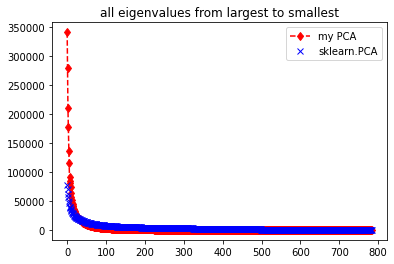

In [ ]:
# plot all eigenvalues from largest to smallest

plt.title('all eigenvalues from largest to smallest')
plt.plot(w,'rd--', pca.singular_values_, 'xb')
plt.legend(['my PCA', 'sklearn.PCA'])

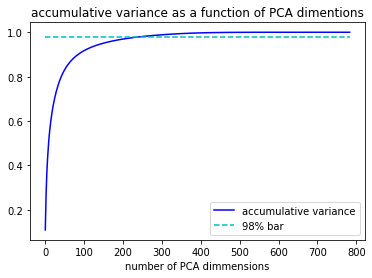

In [ ]:
#plot the accumulative variance as a function of PCA dimentions

total_var = np.cumsum(w)/np.sum(w)

plt.title('accumulative variance as a function of PCA dimentions')
plt.xlabel('number of PCA dimmensions')
plt.plot(total_var, 'b', 0.98*np.ones(total_var.shape[0]), 'c--')
plt.legend(['accumulative variance', '98% bar'])

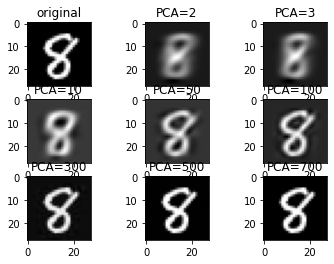

In [ ]:
# restore PCA back to the original space 

x = X8[200,:]  #specify any training image for recovery 

w,A = my_PCA(X, X.shape[1]) 

fig = plt.figure()

img = x.reshape(28,-1)  #reshape each image from 1x784 to 28x28 for display
ax = fig.add_subplot(3,3,1)
ax.title.set_text('original')

plt.imshow(img, cmap='gray')

n = 2
for m in [2, 3, 10, 50, 100, 300, 500, 700]:
  A_m = A[:m,:]
  y = np.transpose(A_m @ x.T)

  # recovery formula on page 83
  #x_hat = y @ A_m    
  # recovery formula from Q4.3 on page 93
  x_hat = y @ A_m + (np.identity(A_m.shape[1]) - A_m.T @ A_m) @ X.mean(axis=0) 

  img = x_hat.reshape(28,-1) 
  ax = fig.add_subplot(3,3,n)
  label = "PCA=%d" % m
  ax.title.set_text(label)
  plt.imshow(img, cmap='gray')
  n = n+1

plt.show(block=True)

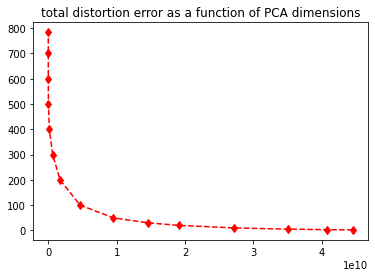

In [ ]:
#plot the total distortion error as a function of PCA dimensions

M = X.shape[1]
w,A = my_PCA(X,M) 

m_array = [2,3,5,10,20,30,50,100,200,300,400,500,600,700,784]
error = np.zeros(len(m_array))

k=0
for m in m_array:
  A_m = A[:m,:]

  # PCA projection
  Y = np.transpose(A_m @ X.T)

  # recovery formula on page 83
  #X_hat = Y @ A_m  

  # recovery formula from Q4.3 on page 93
  X_hat = Y @ A_m + (np.identity(A_m.shape[1]) - A_m.T @ A_m) @ X.mean(axis=0)

  error[k] = np.sum((X-X_hat)*(X-X_hat)) 
  k = k+1 

plt.title('total distortion error as a function of PCA dimensions')
plt.plot(error, m_array,'rd--')

## **II. Dimension Reduction with t-SNE**



### **Example 1.2  Apply t-SNE to MNIST images**

 Use a popular nonlinear method, namely, *t-SNE*, to conduct nonlinear dimension reduction on all MNIST training images of three digits (4, 7, and 8). Use the existing t-SNE implementation in *scikit-learn* for this question. 

In [ ]:
# use t-SNE implementation sklearn
from sklearn.manifold import TSNE

# WARNING: t-SNE is fairly slow in large data sets 

# 2D t-SNE
Y_tsne = TSNE(n_components=2,  perplexity=20).fit_transform(X)

# 3D t-SNE
Y_tsne = TSNE(n_components=3,  perplexity=20).fit_transform(X)

## **III. Data Visualization**

### **Example 1.3  Visualizing MNIST images in 2D/3D space**

Use the above PCA and t-SNE to project all MNIST training images of three digits (4, 7, and 8) into 2D and 3D spaces, and plot each digit in a different color for data visualization in 2D and 3D spaces. Explain how these methods differ in data visualization.


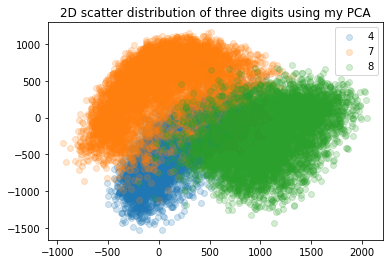

In [ ]:
# 2D visualization scatter for three digits using 2D PCA  

w,A = my_PCA(X, 2)

X4 = train_data[train_label == 4]
Y4 = np.transpose(A @ X4.T)
X7 = train_data[train_label == 7]
Y7 = np.transpose(A @ X7.T)
X8 = train_data[train_label == 8]
Y8 = np.transpose(A @ X8.T)

plt.title('2D scatter distribution of three digits using my PCA')
plt.scatter(x=Y4[:, 0], y=Y4[:, 1], color='#1f77b4', alpha=0.20, label='4')
plt.scatter(x=Y7[:, 0], y=Y7[:, 1],  color='#ff7f0e', alpha=0.20, label='7')
plt.scatter(x=Y8[:, 0], y=Y8[:, 1], color='#2ca02c', alpha=0.20, label='8')
plt.legend(['4', '7', '8'])

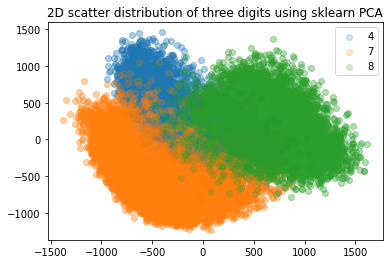

In [ ]:
# 2D visulization for three digits using sklearn PCA  

pca = PCA(n_components=2)
pca.fit(X)

X4 = train_data[train_label == 4]
Y4 = pca.transform(X4)
X7 = train_data[train_label == 7]
Y7 = pca.transform(X7)
X8 = train_data[train_label == 8]
Y8 = pca.transform(X8)

plt.title('2D scatter distribution of three digits using sklearn PCA')
plt.scatter(x=Y4[:, 0], y=Y4[:, 1], color='#1f77b4', alpha=0.20, label='4')
plt.scatter(x=Y7[:, 0], y=Y7[:, 1],  color='#ff7f0e', alpha=0.20, label='7')
plt.scatter(x=Y8[:, 0], y=Y8[:, 1], color='#2ca02c', alpha=0.20, label='8')
plt.legend(['4', '7', '8'])  


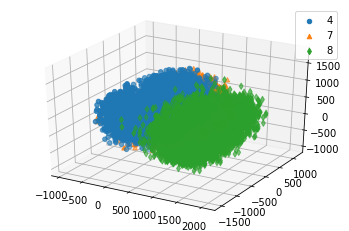

In [ ]:
# plot 3D scatter for three digits using 3D PCA 

w,A = my_PCA(X, 3)

X4 = train_data[train_label == 4]
Y4 = np.transpose(A @ X4.T)
X7 = train_data[train_label == 7]
Y7 = np.transpose(A @ X7.T)
X8 = train_data[train_label == 8]
Y8 = np.transpose(A @ X8.T)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(xs=Y4[:, 0], ys=Y4[:, 1], zs= Y4[:, 2], marker='o', color='#1f77b4')
ax.scatter(xs=Y7[:, 0], ys=Y7[:, 1], zs= Y7[:, 2], marker='^', color='#ff7f0e')
ax.scatter(xs=Y8[:, 0], ys=Y8[:, 1], zs= Y8[:, 2], marker='d', color='#2ca02c')
ax.legend(['4', '7', '8'])

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


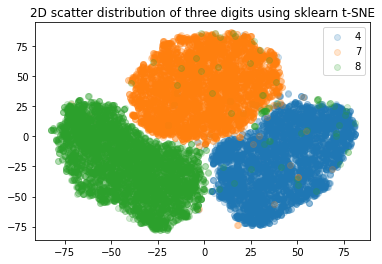

In [ ]:
# use 2D visualization using 2D t-SNE implementation from sklearn
from sklearn.manifold import TSNE

# 2D t-SNE
Y_tsne = TSNE(n_components=2,  perplexity=20).fit_transform(X)

label_478 = train_label[digit_index]

Y4 = Y_tsne[label_478 == 4]
Y7 = Y_tsne[label_478 == 7]
Y8 = Y_tsne[label_478 == 8]

plt.title('2D scatter distribution of three digits using sklearn t-SNE')
plt.scatter(x=Y4[:, 0], y=Y4[:, 1], color='#1f77b4', alpha=0.20, label='4')
plt.scatter(x=Y7[:, 0], y=Y7[:, 1],  color='#ff7f0e', alpha=0.20, label='7')
plt.scatter(x=Y8[:, 0], y=Y8[:, 1], color='#2ca02c', alpha=0.20, label='8')
plt.legend(['4', '7', '8'])

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


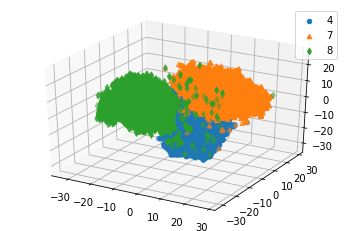

In [ ]:
# use 3D visualization using 3D t-SNE implementation from sklearn
from sklearn.manifold import TSNE

# 3D t-SNE
Y_tsne = TSNE(n_components=3,  perplexity=20).fit_transform(X)

label_478 = train_label[digit_index]

Y4 = Y_tsne[label_478 == 4]
Y7 = Y_tsne[label_478 == 7]
Y8 = Y_tsne[label_478 == 8]

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(xs=Y4[:, 0], ys=Y4[:, 1], zs= Y4[:, 2], marker='o', color='#1f77b4')
ax.scatter(xs=Y7[:, 0], ys=Y7[:, 1], zs= Y7[:, 2], marker='^', color='#ff7f0e')
ax.scatter(xs=Y8[:, 0], ys=Y8[:, 1], zs= Y8[:, 2], marker='d', color='#2ca02c')
ax.legend(['4', '7', '8'])

## **Exercises**

### **Problem 1.1**

Use all training images of three digits (4, 7, and 8) to estimate LDA projection matrices for all possible LDA dimensions. What are the maximum LDA dimensions you can use in this case? Use LDA to project all images into 2D  and 3D space, and compare its visualization with those of PCA and t-SNE. 

### **Problem 1.2**

Instead of use an existing implementation, use the stochastic gradient descent (SGD) method to implement t-SNE (as described in Section 4.3.3 on page 89) from scratch. Compare your implementation with the *scikit-learn* implementation in terms of visualization performance and training speed. 

### **Problem 1.3**

Repeat **Examples 1.1, 1.2, 1.3** and **Problem 1.1** using the  training images of all 10 digits in MNIST. Based on the PCA, LDA and t-SNE projections, visualize all 10 digits in 2D and 3D spaces. 